<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [5]</a>'.</span>

In [11]:
%cd ../
%config InlineBackend.figure_format='retina'

import altair as alt
import seaborn as sns
from IPython import get_ipython
from src.gabor_analysis.gabor_fit import GaborFit
from src.receptive_field.rf import ReceptiveField
from src.spikeloader import SpikeLoader
from src.utils.plots import gabor_interactive

import numpy as np

get_ipython().run_line_magic("matplotlib", "inline")
get_ipython().run_line_magic("config", "InlineBackend.figure_format='retina'")
sns.set()

/groups/stringer/home/josephs2/janelia2020


# Load data

In [12]:
# path_loader = "data/superstim_TX60_allsort.hdf5"
# path_rf = "data/superstim_TX60_allsort.hdf5"
# path_gabor = "data/superstim_TX60_allsort_gabor.hdf5"

In [13]:
# Parameters
path_npz = "/groups/stringer/home/josephs2/data/text32_500_TX59_2020_08_18_coding_neurons_TRUE.npy"
path_hdf5 = "/groups/stringer/home/josephs2/data/text32_500_TX59_2020_08_18_coding_neurons_TRUE.hdf5"
path_img = "/groups/pachitariu/pachitariulab/data/STIM/text32_500_old.mat"
path_loader = "/groups/stringer/home/josephs2/data/text32_500_TX59_2020_08_18_coding_neurons_TRUE.hdf5"
path_rf = "/groups/stringer/home/josephs2/data/text32_500_TX59_2020_08_18_coding_neurons_TRUE.hdf5"
path_gabor = "/groups/stringer/home/josephs2/data/text32_500_TX59_2020_08_18_coding_neurons_TRUE.hdf5"


In [14]:
rf_pcaed = np.load("/groups/stringer/home/josephs2/data/text32_500_TX59_2020_08_18rf_pcaed.npy")

In [15]:
rf_dim = np.array((rf_pcaed.shape[2] // 2, rf_pcaed.shape[1] // 2))


<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [16]:
f = SpikeLoader.from_hdf5(path_loader)
rf = ReceptiveField.from_hdf5(path_rf)
g = GaborFit.from_hdf5(path_gabor)

dict_keys(['cls', 'path', 'load_prev_run', 'kwargs'])
<class 'src.spikeloader.SpikeLoader'>
/groups/stringer/home/josephs2/data/text32_500_TX59_2020_08_18_coding_neurons_TRUE.hdf5
True
{}
dict_keys(['cls', 'path', 'load_prev_run', 'kwargs'])
<class 'src.receptive_field.rf.ReceptiveField'>
/groups/stringer/home/josephs2/data/text32_500_TX59_2020_08_18_coding_neurons_TRUE.hdf5
True
{}
dict_keys(['cls', 'path', 'load_prev_run', 'kwargs'])
<class 'src.gabor_analysis.gabor_fit.GaborFit'>
/groups/stringer/home/josephs2/data/text32_500_TX59_2020_08_18_coding_neurons_TRUE.hdf5
True
{}


In [17]:
import sys
import numpy as np
sys.path.append("../")
sys.path.append("../approxineuro")
from Farah.neural_utils import denoise_spks, stim_preprocess
import os

dat = np.load(path_npz, allow_pickle=True)
dat = dat[()]

In [18]:
def process_neural_data(file_path):
    dat = np.load(file_path, allow_pickle=True)
    dat = dat[()]
    spks = dat['spks'][:, dat['frame_start']]
    print('load data done!')
    print('spks shape: ', spks.shape)
    # zscore neural activity
    spks = spks - spks.mean(axis=1)[:, np.newaxis]
    spks = spks / (spks**2).mean(axis=1)[:, np.newaxis]**.5
    NN, NT = spks.shape
    nstim = NT
    istim = dat['istim'][:nstim]
    print('istim shape: ', istim.shape)
    xpos = dat['xpos']
    ypos = dat['ypos']
    return spks, istim, xpos, ypos

In [19]:
def load_stim_data(file_path, istim, Lyd, Lxd):
    stims = scipy.io.loadmat(file_path, squeeze_me=True)
    # images that were shown
    img = stims['img']
    Ly, Lx, _  = img.shape
    wx = 0
    dx = 0
    # downsample images
    nstim = len(istim)
    Z = np.zeros((nstim, Lyd, Lxd))
    for j in range(nstim):
        I = img[:,:,istim[j]].copy()
        I = cv2.resize(I, (Lxd, Lyd))        
        I = np.float64(I)
        Z[j] = I - np.mean(I)    
    Z = np.reshape(Z, (nstim, -1))
    mu = Z.mean(axis=0)
    std = Z.std()
    Z -= mu
    Z /= std  # (NT, Lyd*Lxd)
    print('load stimuli done! shape: ', Z.shape)
    return Z

In [20]:
import scipy
import cv2
spks, istim, xpos, ypos = process_neural_data(path_npz)
Z = load_stim_data(path_img, istim, 18, 48)

load data done!
spks shape:  (2034, 13860)
istim shape:  (13860,)
load stimuli done! shape:  (13860, 864)


# Make gabor model

In [21]:
# import jax
# import jax.numpy as jnp
# from jax.numpy import cos, exp, sin

# jax.config.update('jax_platform_name', 'cpu')

def make_gabor(params, rf_dim):
    """
    Args:
        A: ngabors x parameters
        X: x, y coordinates
    Returns:
        F
    """
    σ, θ, λ, γ, φ = [
            u[:, np.newaxis, np.newaxis]
            for u in (params[:, 0], params[:, 1], params[:, 2], params[:, 3], params[:, 4])
        ]
    n = params.shape[0]
    pos_x, pos_y = [u[:, np.newaxis, np.newaxis] for u in (params[:, 5], params[:, 6])]
    x, y = np.meshgrid(
        np.arange(-rf_dim[0], rf_dim[0]), np.arange(-rf_dim[1], rf_dim[1])
    )
    x = np.repeat(x[np.newaxis, :, :], n, axis=0)
    y = np.repeat(y[np.newaxis, :, :], n, axis=0)
    xp = (pos_x - x) * np.cos(θ) - (pos_y - y) * np.sin(θ)
    yp = (pos_x - x) * np.sin(θ) + (pos_y - y) * np.cos(θ)
    output = np.exp(-(xp ** 2 + (γ * yp) ** 2) / (2 * σ ** 2)) * np.cos(2 * np.pi * xp / λ + φ)
    return output

In [22]:
gabor_img = make_gabor(np.array(g.params_fit), rf_dim)

<ipython-input-21-9291398c5dd5>:28: RuntimeWarning: divide by zero encountered in true_divide
  output = np.exp(-(xp ** 2 + (γ * yp) ** 2) / (2 * σ ** 2)) * np.cos(2 * np.pi * xp / λ + φ)
<ipython-input-21-9291398c5dd5>:28: RuntimeWarning: invalid value encountered in true_divide
  output = np.exp(-(xp ** 2 + (γ * yp) ** 2) / (2 * σ ** 2)) * np.cos(2 * np.pi * xp / λ + φ)
<ipython-input-21-9291398c5dd5>:28: RuntimeWarning: invalid value encountered in cos
  output = np.exp(-(xp ** 2 + (γ * yp) ** 2) / (2 * σ ** 2)) * np.cos(2 * np.pi * xp / λ + φ)


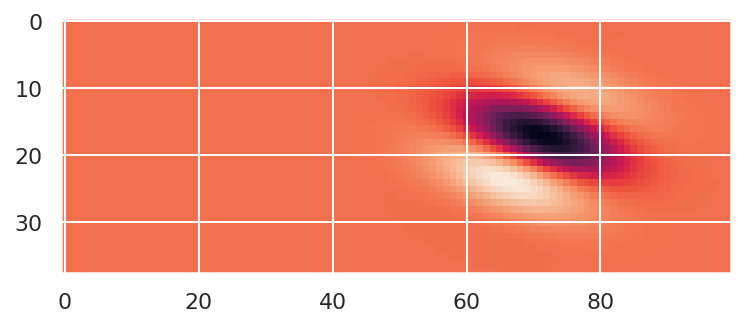

In [23]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(gabor_img[46,:,:])

In [24]:
gabor_img.shape

(2034, 38, 100)

In [25]:
# downsample b/c of the PCA model
Lyd, Lxd = 18, 48
dgab = np.zeros((len(gabor_img), Lyd, Lxd))
for j in range(len(gabor_img)):
    I = gabor_img[j,:,:].copy()
    I = cv2.resize(I, (Lxd, Lyd))        
    I = np.float64(I)
    dgab[j] = I - np.mean(I)    

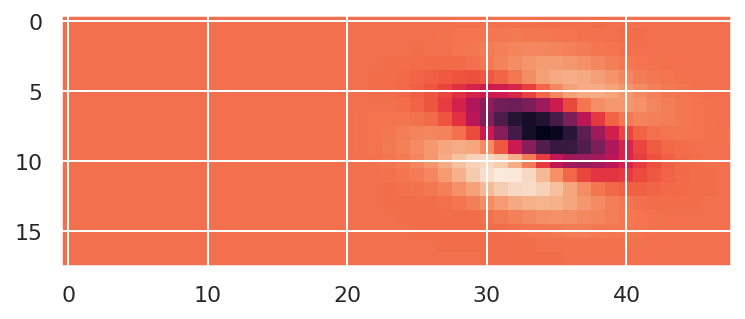

In [26]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(dgab[46,:,:])

In [27]:
pred = dgab.reshape(2034, -1) @ Z.T

In [28]:
# Pearson's
from scipy.stats import pearsonr
total_pearson = []
for i in range(len(pred)):
    try:
        r, p = pearsonr(pred[i, :],spks[i, :])
    except:
        print(pred[i,:])
    total_pearson.append(r)

[nan nan nan ... nan nan nan]


# Examine results

0.1548451817456084

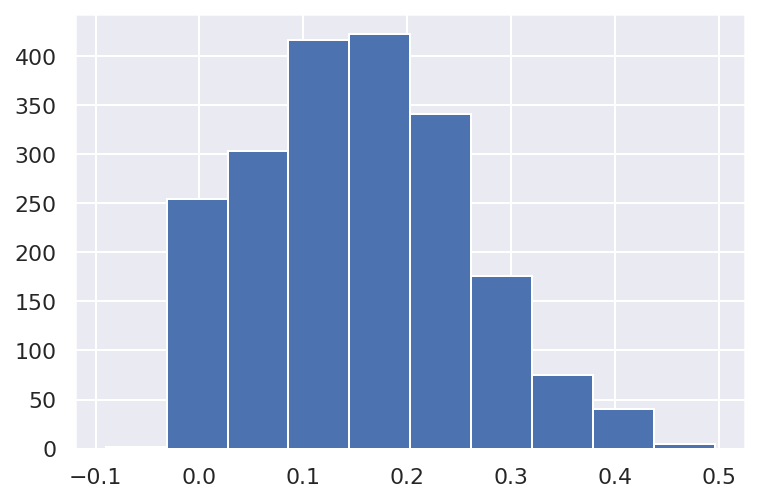

In [29]:
# Calculate Pearson's
plt.figure()
plt.hist(total_pearson)
cleaned_pearson = [x for x in total_pearson if str(x) != 'nan']
np.mean(cleaned_pearson)

In [30]:
g_par = np.array(g.params_fit)
g_par.shape

(2034, 8)

In [31]:
g.params_fit.columns

Index(['σ', 'θ', 'λ', 'γ', 'φ', 'pos_x', 'pos_y', 'corr'], dtype='object')

## Histogram of parameters

<Figure size 360x72 with 0 Axes>

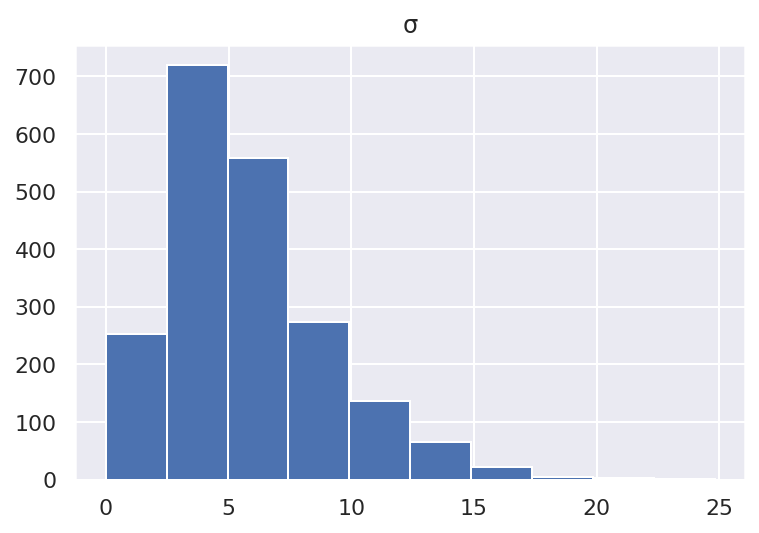

<Figure size 360x72 with 0 Axes>

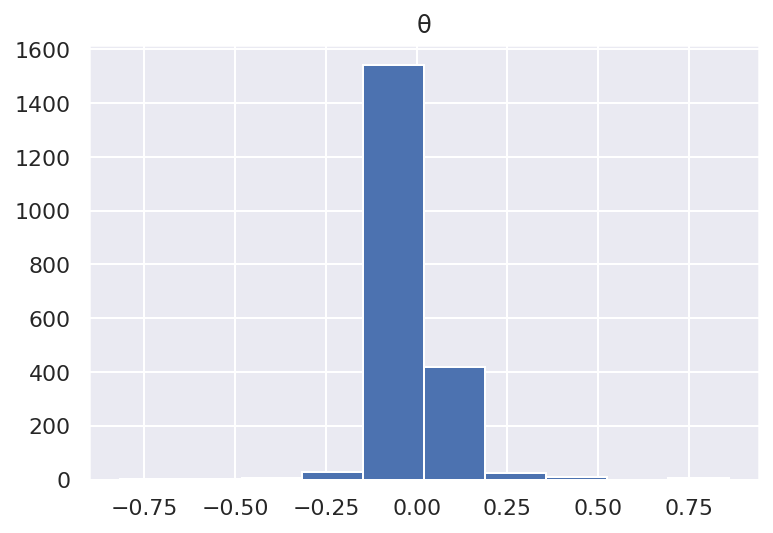

<Figure size 360x72 with 0 Axes>

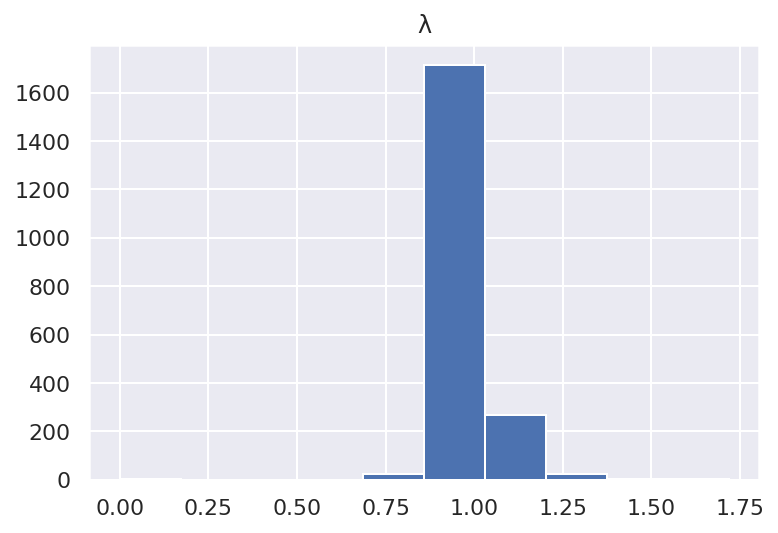

<Figure size 360x72 with 0 Axes>

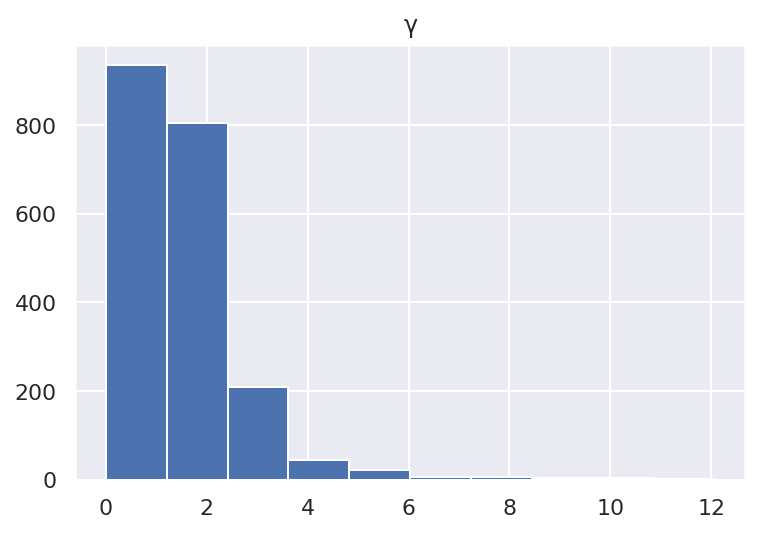

<Figure size 360x72 with 0 Axes>

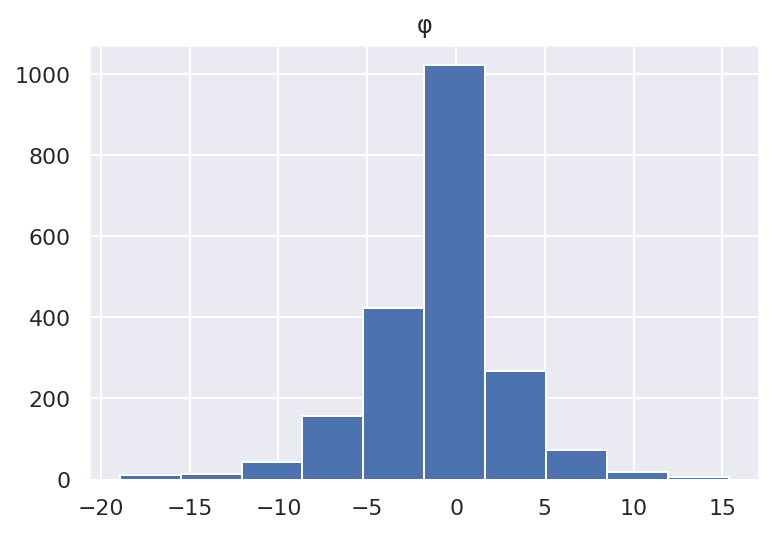

<Figure size 360x72 with 0 Axes>

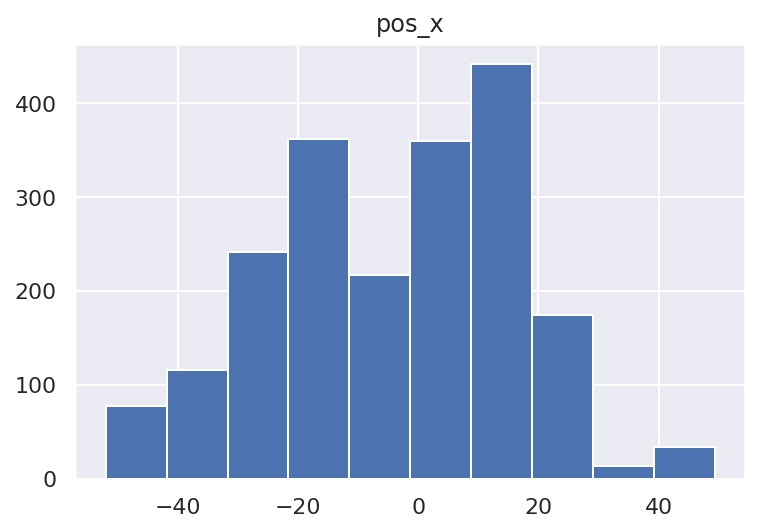

<Figure size 360x72 with 0 Axes>

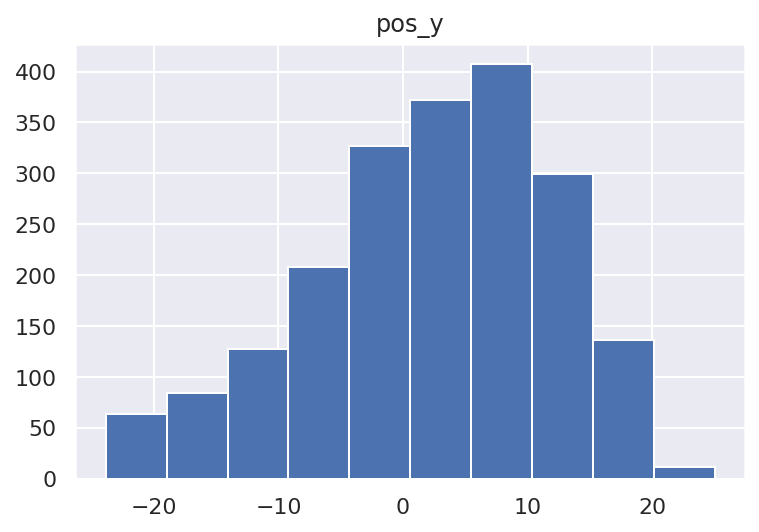

<Figure size 360x72 with 0 Axes>

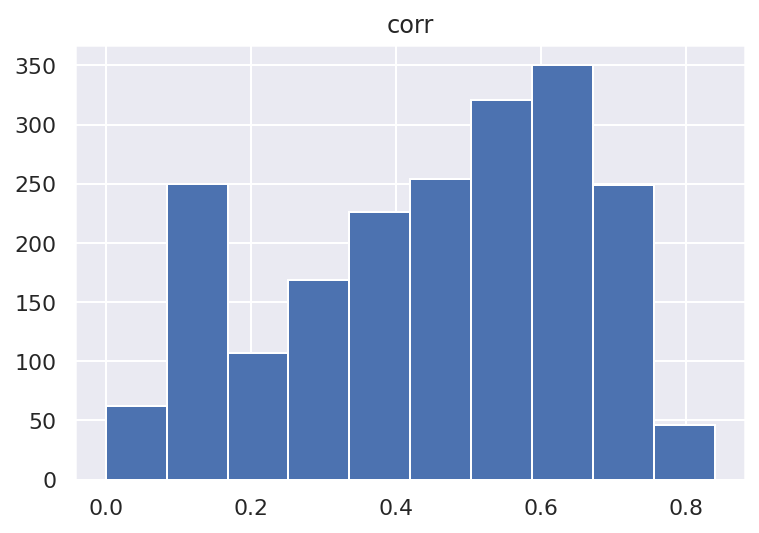

In [32]:
# Histogram of parameters
for i in g.params_fit.columns:
    plt.figure(figsize=(5,1))
    g.params_fit.hist(column=i)
    plt.title(i)

In [33]:
pred = np.nan_to_num(pred)

## Neural trace

NameError: name 'pred_relu' is not defined

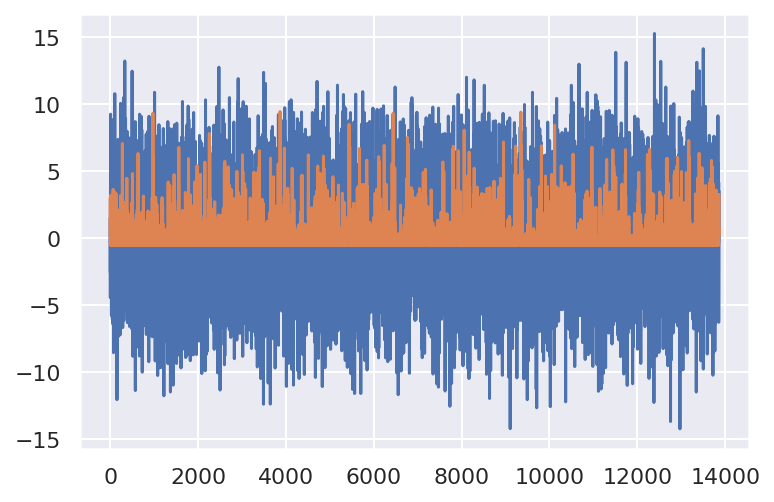

In [34]:
# Plot neural trace
import matplotlib.pyplot as plt
plt.figure()
plt.plot(pred[0], label="prediction")
plt.plot(spks[0], label="original")
plt.plot(pred_relu[0], label='relu')
plt.legend()

In [ ]:
# Take ReLU first
pred_relu = np.maximum(0, pred)

# Logistic Regression

In [ ]:
# Logistic Regression
from Farah.neural_utils import split_train_test_data
from sklearn.linear_model import LogisticRegression
Xtr, ytr, Xte, yte, X, y = split_train_test_data(pred_relu, istim, D=-1, n_cls=32)
clf = LogisticRegression(random_state=0, penalty='l2', C=100).fit(Xtr, ytr)
print("n training samples: ", len(Xtr))
print("n test samples: ", len(Xte))
acc = clf.score(Xte, yte)
print('Logistic Regression Test Accuracy for Predicted Neurons: ', acc)
